In [13]:
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [14]:
coffee_data = './Data/Coffee/'

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
input_shape = (224,224,3)
batch_size = 16


train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = .2,
    height_shift_range = .2,
    shear_range = .2,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    featurewise_center=True,
    featurewise_std_normalization=True,
    fill_mode = 'nearest',
    validation_split = 0.3
)

train_generator = train_datagen.flow_from_directory(
    coffee_data,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    coffee_data,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

test_generator = train_datagen.flow_from_directory(
    coffee_data,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation'
)

Found 780 images belonging to 4 classes.
Found 331 images belonging to 4 classes.
Found 331 images belonging to 4 classes.


In [16]:
def mobilenetv2():
  
    mobilenet_m = tf.keras.applications.vgg19.VGG19(input_shape=input_shape,
                                                                include_top = False,
                                                                weights = 'imagenet'
                                                                )
    x = mobilenet_m.trainable = False
    x = mobilenet_m.output

    x = GlobalAveragePooling2D()(x)
    out = Dense(4,activation='softmax')(x)
    
    model = Model(inputs = mobilenet_m.inputs, outputs = out)

    model.summary() 

    return model

In [17]:
mobilenetv2_model = mobilenetv2()
mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = .0001),metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [18]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='Coffee_model2.h5',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history = mobilenetv2_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data = validation_generator,
    epochs = 50,
    callbacks=callbacks,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)


duration = datetime.now() - start
print("Training complete in time: ", duration)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 6.8366 - accuracy: 0.1728
Epoch 1: val_loss improved from inf to 4.47640, saving model to Coffee_model2.h5
48/48 [==============================] - 67s 1s/step - loss: 6.8366 - accuracy: 0.1728 - val_loss: 4.4764 - val_accuracy: 0.1719
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 4.0071 - accuracy: 0.2304
Epoch 2: val_loss improved from 4.47640 to 3.67094, saving model to Coffee_model2.h5
48/48 [==============================] - 61s 1s/step - loss: 4.0071 - accuracy: 0.2304 - val_loss: 3.6709 - val_accuracy: 0.2438
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 3.5438 - accuracy: 0.2919
Epoch 3: val_loss did not improve from 3.67094
48/48 [==============================] - 58s 1s/step - loss: 3.5438 - accuracy: 0.2919 - val_loss: 3.7602 - val_accuracy: 0.2906
Epoch 4/50
48/48 [==============================] - ETA: 0s - loss: 3.3020 - accuracy: 0.3207
Epoch 4: val_loss did no

In [19]:
mobilenetv2_model.evaluate(test_generator)

21/21 [==============================] - 18s 818ms/step - loss: 1.6880 - accuracy: 0.4653


[1.687996745109558, 0.46525681018829346]

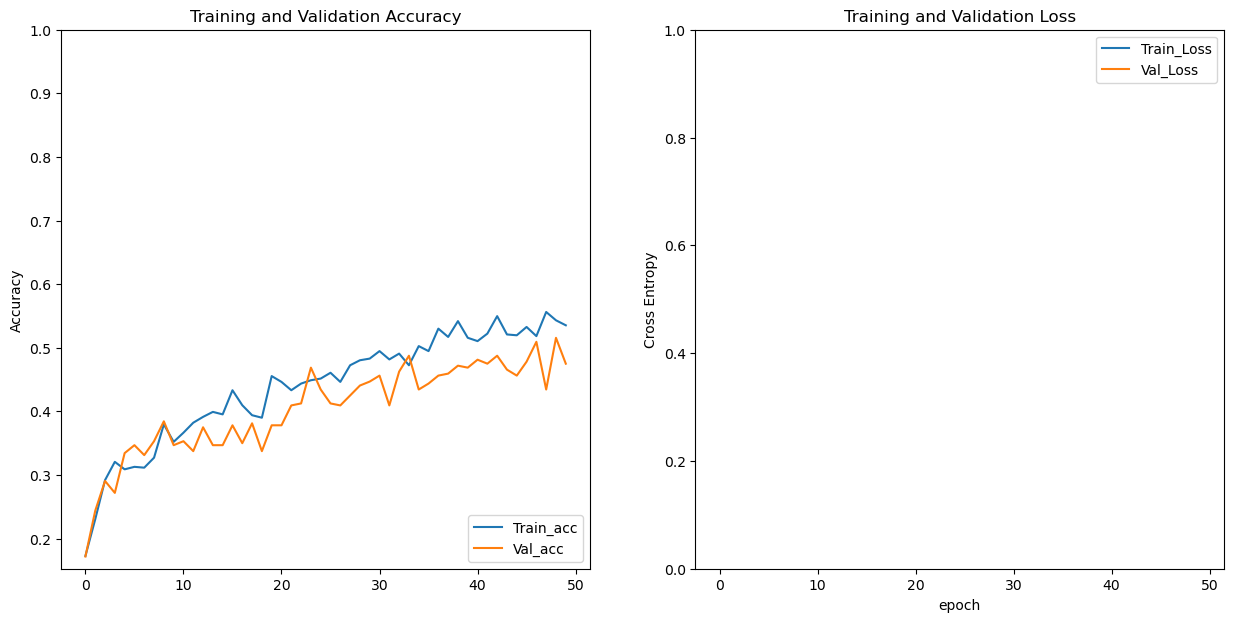

In [20]:
### Loss and accuracy plot
acc_mob = model_history.history['accuracy']
val_acc_mob = model_history.history['val_accuracy']

loss_mob = model_history.history['loss']
val_loss_mob = model_history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_Loss')
plt.plot(val_loss_mob, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
## Unfreezing layers
mobilenetv2_model.trainable = True


## Fine-tuning
## number of layer in the pre-trained model
print('Number of layer in the pre-trained model:{}'.format(len(mobilenetv2_model.layers)))
fine_tune_at = 100

for layer in mobilenetv2_model.layers[:fine_tune_at]:
  layer.trainable = False
print(f"Trainable Layers: {len(mobilenetv2_model.trainable_variables)}")

Number of layer in the pre-trained model:24
Trainable Layers: 0


In [22]:
mobilenetv2_model.summary()
mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001/10),metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [23]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


fine_tune_epochs = 50
total_epochs = 50 + fine_tune_epochs
checkpoint = ModelCheckpoint(filepath='Coffee_model2.h5',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history = mobilenetv2_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    initial_epoch = model_history.epoch[-1],
    validation_data = validation_generator,
    epochs = total_epochs,
    callbacks=callbacks,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)


duration = datetime.now() - start
print("Training complete in time: ", duration)

Epoch 50/100
48/48 [==============================] - ETA: 0s - loss: 1.2872 - accuracy: 0.5851
Epoch 50: val_loss improved from inf to 1.44919, saving model to Coffee_model2.h5
48/48 [==============================] - 62s 1s/step - loss: 1.2872 - accuracy: 0.5851 - val_loss: 1.4492 - val_accuracy: 0.5188
Epoch 51/100
48/48 [==============================] - ETA: 0s - loss: 1.4087 - accuracy: 0.5340
Epoch 51: val_loss improved from 1.44919 to 1.43107, saving model to Coffee_model2.h5
48/48 [==============================] - 58s 1s/step - loss: 1.4087 - accuracy: 0.5340 - val_loss: 1.4311 - val_accuracy: 0.5094
Epoch 52/100
48/48 [==============================] - ETA: 0s - loss: 1.4189 - accuracy: 0.5537
Epoch 52: val_loss did not improve from 1.43107
48/48 [==============================] - 58s 1s/step - loss: 1.4189 - accuracy: 0.5537 - val_loss: 1.5593 - val_accuracy: 0.4906
Epoch 53/100
48/48 [==============================] - ETA: 0s - loss: 1.3695 - accuracy: 0.5537
Epoch 53: val

In [24]:
mobilenetv2_model.evaluate(test_generator)

21/21 [==============================] - 13s 573ms/step - loss: 1.4689 - accuracy: 0.4924


[1.46889066696167, 0.4924471378326416]